#  Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [50]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
import os

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('./database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
positiveNegative.shape

(525814,)

In [4]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

#  Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

# Time Based Splitting 

In [6]:
#Sorting data according to Time Stamp in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)
label=np.array(final['Score'])

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

##   Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

8
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [11]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'of', 'aren', 'yourself', 'under', 'that', "you're", "hadn't", 'ma', 'such', 'him', "you've", 'those', 'again', 'with', "isn't", 'what', 'just', 'needn', 'he', "shouldn't", 'own', "should've", 've', 'and', 'won', 'themselves', 'from', 'for', 'down', 'mightn', 'me', 'by', 'myself', 'd', 'hers', "shan't", 'y', 'mustn', 'nor', 'until', 'your', "didn't", 'it', 'which', 'to', 'more', "don't", 'were', 'can', 'too', 'through', 'them', 'do', 'few', 'be', 'm', 'hadn', 'each', 'no', 'am', 'we', 'is', "wasn't", 's', 'haven', 'her', "that'll", 'these', 'any', 'the', 'before', 'being', "wouldn't", 'shan', 'but', "hasn't", 'having', 'this', 'was', 'above', "you'd", "won't", 'itself', 'weren', 't', 'are', 'not', 'against', 'shouldn', 'about', 'wasn', 'or', "aren't", 'after', 'below', 'couldn', 'their', 'ourselves', 'all', 'its', 'they', 'while', 'into', "doesn't", 'during', 'you', 'here', 'over', 'our', 'ain', 'who', 'than', 'now', 'whom', 'most', 'further', 'when', 'a', 'both', 'doesn', 'between', 

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [14]:
print(final.head(3))#below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

            Id   ProductId         UserId         ProfileName  \
138706  150524  0006641040  ACITT7DI6IDDL     shari zychinski   
138683  150501  0006641040  AJ46FKXOVC7NR  Nicholas A Mesiano   
417839  451856  B00004CXX9  AIUWLEQ1ADEG5    Elizabeth Medina   

        HelpfulnessNumerator  HelpfulnessDenominator     Score       Time  \
138706                     0                       0  positive  939340800   
138683                     2                       2  positive  940809600   
417839                     0                       0  positive  944092800   

                                                  Summary  \
138706                          EVERY book is educational   
138683  This whole series is great way to spend time w...   
417839                               Entertainingl Funny!   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138683  I can remember seeing the show when it aired o...   
41

In [15]:
label[0]

'positive'

In [16]:
i=0
j=label.size
labels=[]
for i in range(0,j):
    if label[i]=='positive':
        labels.append(1)
    else:
        labels.append(0)
    


In [17]:
finals=final[0:]
print(labels[0])

1


In [18]:
from sklearn import cross_validation
final_Train, final_Test, label_Train, label_Test = cross_validation.train_test_split(finals,labels, test_size=0.3, random_state=0)

In [19]:
print(label_Train[0])

1


In [20]:
print(label_Test[0:10])

[1, 1, 1, 1, 0, 0, 1, 0, 1, 1]


#  Bag of Words (BoW)

In [21]:
count_vec = CountVectorizer()
final_Tr1 = count_vec.fit_transform(final_Train['CleanedText'].values)
final_Te1 = count_vec.transform(final_Test['CleanedText'].values)

In [22]:
# standardizing data
from sklearn import preprocessing
min_max_scaler = preprocessing.StandardScaler(with_mean=False)
final_Tr = min_max_scaler.fit_transform(final_Tr1)
final_Te = min_max_scaler.transform(final_Te1)

C:\Users\Dileep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [23]:
features = count_vec.get_feature_names()
features[23333]

'hacker'

In [24]:
final_Te.shape

(109252, 60218)

In [25]:
type(final_Te)

scipy.sparse.csr.csr_matrix

In [26]:
final_Tr.shape

(254919, 60218)

# k fold cross Validation

In [87]:

myList = [10**-4, 10**-2, 10**0, 10**2, 10**4]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in myList:
    LGR = LogisticRegression(C=k)
    scores = cross_val_score(LGR, final_Tr, label_Train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

optimal_c = myList[MSE.index(min(MSE))]
print('\nThe optimal lamda is %f.' % optimal_c)


The optimal lamda is 0.000100.


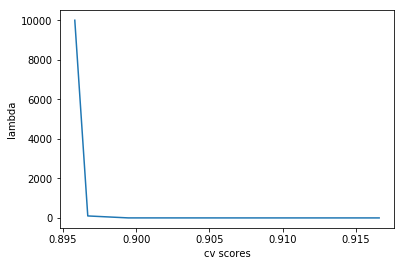

In [88]:
plt.plot(cv_scores,myList)
plt.xlabel('cv scores')
plt.ylabel('lambda')
plt.show()

In [89]:
print(cv_scores)

[0.9165930886220449, 0.9069272888028337, 0.8994543294898965, 0.8966926773882363, 0.89580611135619]


In [90]:
LGR = LogisticRegression(C=optimal_c)
LGR.fit(final_Tr,label_Train)
pred= LGR.predict(final_Te)
acc = accuracy_score(label_Test, pred, normalize=True) * float(100)
print("\n****Test accuracy for k ={} is {}".format(optimal_c,acc))


****Test accuracy for k =0.0001 is 91.63768169003771


# GridSearchCv

In [91]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5,)
model.fit(final_Tr,label_Train)

print(model.best_estimator_)
print(model.score(final_Te, label_Test))

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9517384919335242


# RandomizedSearchCV

In [92]:
tuned_parameters = {'C': [10**-4, 0.0003, 0.0005, 0.1,0.5 ,10**-2, 10**0, 10**2, 10**4, 1000, 10]}
model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(final_Tr,label_Train)

print(model.best_estimator_)
print(model.score(final_Te, label_Test))

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9517384919335242


In [93]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(final_Tr,label_Train);
w = clf.coef_
print(np.count_nonzero(w))


28270


In [94]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(final_Tr,label_Train);
w = clf.coef_
print(np.count_nonzero(w))


12908


In [95]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

clf = LogisticRegression(C=0.001, penalty='l1');
clf.fit(final_Tr,label_Train);
w = clf.coef_
print(np.count_nonzero(w))


387


In [96]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

clf = LogisticRegression(C=10, penalty='l1');
clf.fit(final_Tr,label_Train);
w = clf.coef_
print(np.count_nonzero(w))


58661


In [97]:
cm=confusion_matrix(label_Test,pred)

In [98]:
tn, fp, fn, tp = confusion_matrix(label_Test,pred).ravel()
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 10033 
 false positives are 7095 
 false positives are 2041
 true positives are 90083 
 


       0      1
0  10033   7095
1   2041  90083


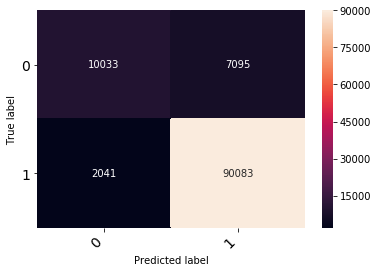

In [99]:
index_names=['0','1']
class_names=['0','1']
df_cm = pd.DataFrame(cm, index=index_names, columns=class_names)
print(df_cm)
hp =sns.heatmap(df_cm, annot=True, fmt="d")
hp.yaxis.set_ticklabels(hp.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
hp.xaxis.set_ticklabels(hp.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [100]:
print("f1-score    ",f1_score(label_Test,pred))
print("precision_score   ",precision_score(label_Test,pred))
#recall score
print("recall_score    ",recall_score(label_Test,pred))
#accuracy score
print("accuracy    ",accuracy_score(label_Test,pred))

f1-score     0.9517384919335242
precision_score    0.926989647862685
recall_score     0.9778450783726282
accuracy     0.9163768169003771


# Multi Collinearity Check

In [30]:
df = pd.DataFrame(['final_Tr'])

# important features for Bag of Words

In [28]:
f=final_Tr.T
fe=np.array(features)
l=np.array([np.sum(i) for i in f])
ids = l.argsort()[::-1][:20]
print(fe[ids])

['like' 'tast' 'good' 'love' 'great' 'one' 'tri' 'flavor' 'product' 'use'
 'get' 'make' 'buy' 'would' 'time' 'realli' 'much' 'dont' 'find' 'best']


# TF-IDF

In [23]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
final_Tr1 = tf_idf_vect.fit_transform(final_Train['CleanedText'].values)
final_Te1 = tf_idf_vect.transform(final_Test['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names()

In [24]:
# standardizing data
from sklearn import preprocessing
min_max_scaler = preprocessing.StandardScaler(with_mean=False)
final_Tr = min_max_scaler.fit_transform(final_Tr1)
final_Te = min_max_scaler.transform(final_Te1)

# k fold cross validation

In [65]:

myList = [10**-4, 10**-2, 10**0, 10**2, 10**4]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in myList:
    LGR = LogisticRegression(C=k)
    scores = cross_val_score(LGR, final_Tr, label_Train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

optimal_c = myList[MSE.index(min(MSE))]
print('\nThe optimal lamda is %f' % optimal_c)


The optimal lamda is 0.000100


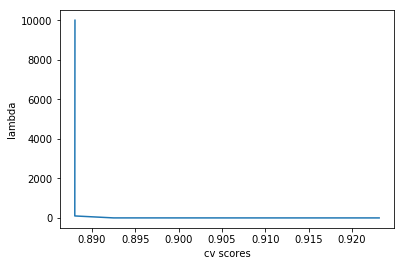

In [66]:
plt.plot(cv_scores,myList)
plt.xlabel('cv scores')
plt.ylabel('lambda')
plt.show()

In [67]:
LGR = LogisticRegression(C=optimal_c)
LGR.fit(final_Tr,label_Train)
pred= LGR.predict(final_Te)
acc = accuracy_score(label_Test, pred, normalize=True) * float(100)
print("\n****Test accuracy for k ={} is {}".format(optimal_c,acc))


****Test accuracy for k =0.0001 is 92.28114817120053


# GridSearchCv

In [68]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5,)
model.fit(final_Tr,label_Train)

print(model.best_estimator_)
print(model.score(final_Te, label_Test))

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9552879797674529


# RandomizedSearchCV

In [69]:
tuned_parameters = {'C': [10**-4, 0.0003, 0.0005, 0.1,0.5 ,10**-2, 10**0, 10**2, 10**4, 1000, 10]}
model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(final_Tr,label_Train)

print(model.best_estimator_)
print(model.score(final_Te, label_Test))

LogisticRegression(C=0.0003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9555159001538726


In [70]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(final_Tr,label_Train);
w = clf.coef_
print(np.count_nonzero(w))


34809


In [71]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(final_Tr,label_Train);
w = clf.coef_
print(np.count_nonzero(w))


16460


In [72]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

clf = LogisticRegression(C=0.001, penalty='l1');
clf.fit(final_Tr,label_Train);
w = clf.coef_
print(np.count_nonzero(w))


483


In [73]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

clf = LogisticRegression(C=10, penalty='l1');
clf.fit(final_Tr,label_Train);
w = clf.coef_
print(np.count_nonzero(w))


48920


In [74]:
cm=confusion_matrix(label_Test,pred)
tn, fp, fn, tp = confusion_matrix(label_Test,pred).ravel()
print(" true negitves are {} \n false positives are {} \n false positives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 10732 
 false positives are 6396 
 false positives are 2037
 true positives are 90087 
 


       0      1
0  10732   6396
1   2037  90087


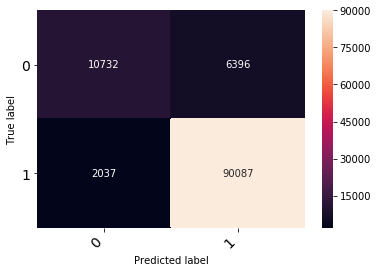

In [75]:
index_names=['0','1']
class_names=['0','1']
df_cm = pd.DataFrame(cm, index=index_names, columns=class_names)
print(df_cm)
hp =sns.heatmap(df_cm, annot=True, fmt="d")
hp.yaxis.set_ticklabels(hp.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
hp.xaxis.set_ticklabels(hp.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [76]:
print("f1-score    ",f1_score(label_Test,pred))
print("precision_score   ",precision_score(label_Test,pred))
#recall score
print("recall_score    ",recall_score(label_Test,pred))
#accuracy score
print("accuracy    ",accuracy_score(label_Test,pred))

f1-score     0.9552879797674529
precision_score    0.9337085289636516
recall_score     0.9778884981112413
accuracy     0.9228114817120052


# important features for tf-idf vectors

In [31]:
f=final_Tr.T
fe=np.array(features)
l=np.array([np.sum(i) for i in f])
ids = l.argsort()[::-1][:20]
print(fe[ids])

['like' 'tast' 'good' 'love' 'great' 'one' 'tri' 'flavor' 'product' 'use'
 'get' 'make' 'buy' 'would' 'time' 'realli' 'much' 'dont' 'find' 'best']


In [32]:
l[ids]

array([138996.79446513, 136845.41447599, 133453.11273314, 132429.98754858,
       130196.1081733 , 117793.42077946, 117205.98127973, 112185.29421208,
       110613.31914671, 109315.16770362, 106115.7907072 , 104980.11978757,
       101137.67876045,  97572.21832973,  94518.59707033,  91414.81448174,
        91326.89126168,  90631.2211558 ,  89393.47626291,  88357.72676927])

# Observation for tf-idf

1.model= K Nearest Neighbours

2.Hyperparameter K=5

3.true negitves are 50

4.false positives are 318 

5.false positives are 12

6.true positives are 2620

7.Test accuracy for k =5 is 89.0

By seeing above observations we can conclude that tf idf classifying most of the positive points correctly.

and mis classifying negative points as positive in most of the cases

#  Word2Vec

In [35]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final_Train['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

C:\Users\Dileep\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [36]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent1=[]
for sent in final_Test['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent1.append(filtered_sentence)
    

In [37]:
from gensim.models import Word2Vec
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [38]:
w2v_words = list(w2v_model.wv.vocab)

In [39]:
len(w2v_words)

18845

In [40]:
print(final_Train['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

This was my first time purchasing malted milk powder, so I can't really say how this measures up to other brands. But what I wanted was straight-up malted milk, not chocolate malt, not a milk shake, just malted milk and this got me there! I just add a couple tablespoons of the powder and a little bit of milk to a mug, microwave it for 20 seconds, stir, then add the rest of my ice cold milk and stir again. Boom! Awesome cold malted milk. Delicious. I fill kind of silly for buying this 2.5lb container (especially since I finally found a reasonable size at a local store). But hey, I'm sure I'll use it :)
*****************************************************************
['first', 'time', 'purchas', 'malt', 'milk', 'powder', 'cant', 'realli', 'say', 'measur', 'brand', 'want', 'malt', 'milk', 'chocol', 'malt', 'milk', 'shake', 'malt', 'milk', 'got', 'add', 'coupl', 'tablespoon', 'powder', 'littl', 'bit', 'milk', 'mug', 'microwav', 'second', 'stir', 'add', 'rest', 'ice', 'cold', 'milk', 'stir

In [41]:
print(final_Test['Text'].values[0])
print("*****************************************************************")
print(list_of_sent1[0])

This is the Best Maple Syrup I have ever tasted and the best deal around with the 50% off sale going on Oct 09! I should order much more! I love its lighter texture than many other maple syrups, and it obviously beats any of the non-maple syrups. This syrup is good enough that small amounts make a great sugar substitute\addition on many things, such as my morning toast, or added to many different types of recipes, instead of sugar. For me, a small amount goes a long way on pancakes, etc. This syrup is great, because you can truly taste the maple and it's not a chemical, and\or molasses mess!
*****************************************************************
['best', 'mapl', 'syrup', 'ever', 'tast', 'best', 'deal', 'around', 'sale', 'go', 'oct', 'order', 'much', 'love', 'lighter', 'textur', 'mani', 'mapl', 'syrup', 'obvious', 'beat', 'syrup', 'syrup', 'good', 'enough', 'small', 'amount', 'make', 'great', 'sugar', 'mani', 'thing', 'morn', 'toast', 'ad', 'mani', 'differ', 'type', 'recip', 

# Avg W2V, TFIDF-W2V

In [42]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

C:\Users\Dileep\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


254919
50


In [43]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors1 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent1: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors1.append(sent_vec)
print(len(sent_vectors1))
print(len(sent_vectors1[0]))

C:\Users\Dileep\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


109252
50


In [44]:
sent_vectors[1]

array([ 0.51568028,  0.69790012, -0.10808969, -0.70764335,  0.26760086,
        0.48469918,  0.24820065, -0.80873391,  0.46596742, -0.14478158,
        0.11020052,  0.47773061, -1.31202574, -0.65974785, -0.16690137,
        0.07471486,  0.64004116,  0.42924016, -0.49289296, -0.11055046,
       -0.44146245,  0.88282028,  0.17409858,  0.06074264,  0.43246453,
       -0.62064371,  1.07576261, -0.11528354, -0.78699247,  0.071487  ,
       -0.71262724, -0.91174459,  0.74876447,  0.44077154,  0.17412533,
       -0.51173802, -0.22375636,  1.35870322, -0.14586006,  1.28401463,
        0.41887886,  0.12681814,  0.66803213,  1.29472813, -0.53503197,
       -0.09523062, -1.0178685 ,  0.56056771,  0.36167679,  0.71099686])

In [45]:
Tr1=np.array(sent_vectors)
inds = np.where(np.isnan(Tr1))
Tr1[inds]=0
Te1=np.array(sent_vectors1)
inds = np.where(np.isnan(Te1))
Te1[inds]=0

In [47]:
# standardizing data
from sklearn import preprocessing
min_max_scaler = preprocessing.StandardScaler(with_mean=False)
Tr = min_max_scaler.fit_transform(Tr1)
Te = min_max_scaler.transform(Te1)

# k fold cross validation

In [64]:

myList = [10**-4, 10**-2, 10**0, 10**2, 10**4]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in myList:
    LGR = LogisticRegression(C=k)
    scores = cross_val_score(LGR, Tr, label_Train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

optimal_c = myList[MSE.index(min(MSE))]
print('\nThe optimal lamda is %f.' % optimal_c)


The optimal lamda is 0.010000.


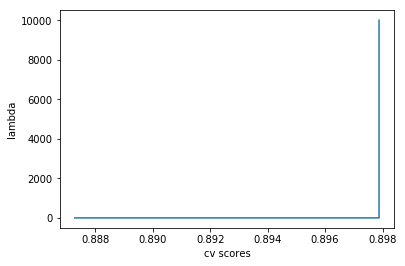

In [121]:
plt.plot(cv_scores,myList)
plt.xlabel('cv scores')
plt.ylabel('lambda')
plt.show()

In [122]:
LGR = LogisticRegression(C=optimal_c)
LGR.fit(Tr,label_Train)
pred= LGR.predict(Te)
acc = accuracy_score(label_Test, pred, normalize=True) * float(100)
print("\n****Test accuracy for k ={} is {}".format(optimal_c,acc))


****Test accuracy for k =1 is 89.67524621974884


# GridSearchCv

In [123]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5,)
model.fit(Tr,label_Train)

print(model.best_estimator_)
print(model.score(Te, label_Test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9404428769047191


# RandomizedSearchCV

In [124]:
tuned_parameters = {'C': [10**-4, 0.0003, 0.0005, 0.1,0.5 ,10**-2, 10**0, 10**2, 10**4, 1000, 10]}
model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(Tr,label_Train)

print(model.best_estimator_)
print(model.score(Te, label_Test))

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9404286098953026


In [125]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(Tr,label_Train);
w = clf.coef_
print(np.count_nonzero(w))


49


In [126]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(Tr,label_Train);
w = clf.coef_
print(np.count_nonzero(w))


46


In [88]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

clf = LogisticRegression(C=0.001, penalty='l1');
clf.fit(Tr,label_Train);
w = clf.coef_
print(np.count_nonzero(w))


35


In [128]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

clf = LogisticRegression(C=10, penalty='l1');
clf.fit(Tr,label_Train);
w = clf.coef_
print(np.count_nonzero(w))


50


In [129]:
cm=confusion_matrix(label_Test,pred)
tn, fp, fn, tp = confusion_matrix(label_Test,pred).ravel()
print(" true negitves are {} \n false positives are {} \n false positives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 8913 
 false positives are 8215 
 false positives are 3065
 true positives are 89059 
 


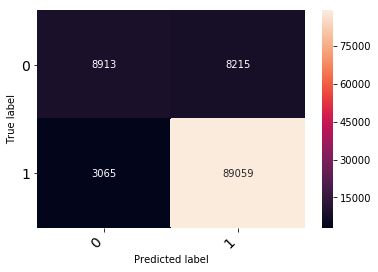

In [130]:
index_names=['0','1']
class_names=['0','1']
df_cm = pd.DataFrame(cm, index=index_names, columns=class_names)
hp =sns.heatmap(df_cm, annot=True, fmt="d")
hp.yaxis.set_ticklabels(hp.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
hp.xaxis.set_ticklabels(hp.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [131]:
print("f1-score    ",f1_score(label_Test,pred))
print("precision_score   ",precision_score(label_Test,pred))
#recall score
print("recall_score    ",recall_score(label_Test,pred))
#accuracy score
print("accuracy    ",accuracy_score(label_Test,pred))

f1-score     0.9404428769047191
precision_score    0.9155478339535744
recall_score     0.9667296252876557
accuracy     0.8967524621974884


# Multi Collinearity Check


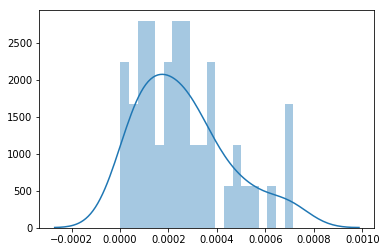

In [49]:
LGR = LogisticRegression(C=0.001)
LGR.fit(Tr,label_Train)
original_weights = LGR.coef_.ravel()
df = pd.DataFrame(Tr)

# Add small noise and then train
final_Tr_with_noise = df.applymap(lambda x: x + np.random.normal(0, 0.01))

LGR.fit(final_Tr_with_noise,label_Train)
noise_weights = LGR.coef_.ravel()


weight_diffs = np.absolute(original_weights - noise_weights)

sns.distplot(weight_diffs, bins=20);


# important Features in Word2Vec

In [87]:
vecsum=[]
words=np.array(w2v_words)
for word in words:
    vec = w2v_model.wv[word]
    vecsum.append(np.sum(vec))
v=np.array(vecsum)
ids = v.argsort()[::-1][:20]
print(words[ids])

['china' 'review' 'label' 'descript' 'vet' 'ship' 'fructos' 'bpa' 'pictur'
 'plant' 'fda' 'corn' 'qualiti' 'cat' 'email' 'usa' 'breed' 'deliveri'
 'ingredi' 'kitten']


# Observation for avg Word2vec

1.model= K Nearest Neighbours

2.Hyperparameter K=3

3.true negitves are 0 

4.false positives are 368 

5.false positives are 0

6.true positives are 2632

7.Test accuracy for k =3 is 87.7333333333333

By seeing above observations we can say that our Model KNN classifying all the points as Positive 

it is fully biased towards positive

# TF-iDF word 2 vec

In [51]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_Train['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [52]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████| 254919/254919 [16:56<00:00, 250.79it/s]


In [53]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors1.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████| 109252/109252 [07:01<00:00, 259.37it/s]


In [54]:
Tra1=np.array(tfidf_sent_vectors)
inds = np.where(np.isnan(Tra1))
Tra1[inds]=0

In [55]:
Tes1=np.array(tfidf_sent_vectors1)
inds = np.where(np.isnan(Tes1))
Tes1[inds]=0

In [38]:
Tra1[8]

array([-0.16341387, -0.02259441,  0.90220196, -0.49518953, -0.36806496,
       -0.05680981, -0.50874561,  0.12368843, -0.57144758,  0.65938835,
       -0.77373686,  0.7440457 , -0.11962319,  0.36997744,  0.8031568 ,
       -0.59391169, -0.04668264,  0.07766321, -0.21170589,  0.61789508,
        0.36484052, -0.60471058, -0.45613283,  0.09263534, -0.21706475,
       -0.05887047,  0.23165692, -0.05284111, -0.77894386, -0.06100857,
       -0.15139603,  0.14466486, -0.10336425,  0.94050676,  0.16882674,
        0.71535811, -0.23382086, -0.55419834,  0.81414543,  0.00237275,
       -0.25717761,  0.74112539,  0.72495486, -0.27552696, -0.31962729,
       -0.56868543, -0.01388539, -0.30392979, -0.33830798,  0.21824415])

In [56]:
# standardizing data
from sklearn import preprocessing
min_max_scaler = preprocessing.StandardScaler(with_mean=False)
Tra = min_max_scaler.fit_transform(Tra1)
Tes = min_max_scaler.transform(Tes1)

# k fold cross validation

In [40]:

myList = [10**-4, 10**-2, 10**0, 10**2, 10**4]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in myList:
    LGR = LogisticRegression(C=k)
    scores = cross_val_score(LGR, Tra, label_Train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

optimal_c = myList[MSE.index(min(MSE))]
print('\nThe optimal lamda is %f.' % optimal_c)


The optimal lamda is 1.000000.


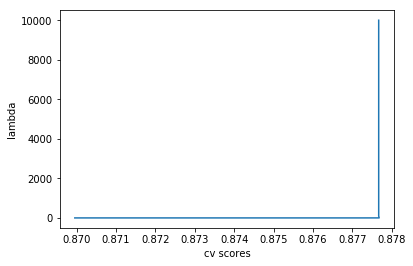

In [41]:
plt.plot(cv_scores,myList)
plt.xlabel('cv scores')
plt.ylabel('lambda')
plt.show()

In [42]:
LGR = LogisticRegression(C=optimal_c)
LGR.fit(Tra,label_Train)
pred= LGR.predict(Tes)
acc = accuracy_score(label_Test, pred, normalize=True) * float(100)
print("\n****Test accuracy for k ={} is {}".format(optimal_c,acc))


****Test accuracy for k =1 is 87.6981657086369


# GridSearchCv

In [43]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5,)
model.fit(Tra,label_Train)

print(model.best_estimator_)
print(model.score(Tes, label_Test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9301048427358962


# RandomizedSearchCV

In [46]:
tuned_parameters = {'C': [10**-4, 0.0003, 0.0005, 0.1,0.5 ,10**-2, 10**0, 10**2, 10**4, 1000, 10]}
model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(Tra,y_train)

print(model.best_estimator_)
print(model.score(Tes, y_test))

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9301055697124135


In [47]:
print(model.score(Tes, y_test))

0.9301055697124135


In [48]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(Tra,label_Train);
w = clf.coef_
print(np.count_nonzero(w))


50


In [49]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(Tra,label_Train);
w = clf.coef_
print(np.count_nonzero(w))


48


In [50]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

clf = LogisticRegression(C=0.001, penalty='l1');
clf.fit(Tra,label_Train);
w = clf.coef_
print(np.count_nonzero(w))


37


In [51]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

clf = LogisticRegression(C=10, penalty='l1');
clf.fit(Tra,label_Train);
w = clf.coef_
print(np.count_nonzero(w))


50


In [54]:
cm=confusion_matrix(label_Test,pred)
tn, fp, fn, tp = confusion_matrix(label_Test,pred).ravel()
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 6388 
 false positives are 10740 
 false negatives are 2700
 true positives are 89424 
 


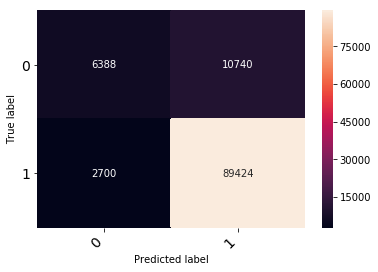

In [55]:
index_names=['0','1']
class_names=['0','1']
df_cm = pd.DataFrame(cm, index=index_names, columns=class_names)
hp =sns.heatmap(df_cm, annot=True, fmt="d")
hp.yaxis.set_ticklabels(hp.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
hp.xaxis.set_ticklabels(hp.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [56]:
print("f1-score    ",f1_score(label_Test,pred))
print("precision_score   ",precision_score(label_Test,pred))
#recall score
print("recall_score    ",recall_score(label_Test,pred))
#accuracy score
print("accuracy    ",accuracy_score(label_Test,pred))

f1-score     0.9301048427358962
precision_score    0.8927758476099197
recall_score     0.9706916764361079
accuracy     0.8769816570863691


# Multi Collinearity heck

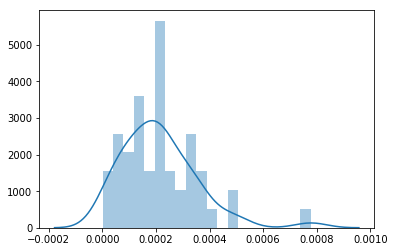

In [57]:
LGR = LogisticRegression(C=0.001)
LGR.fit(Tra,label_Train)
original_weights = LGR.coef_.ravel()
df = pd.DataFrame(Tra)

# Add small noise and then train
final_Tr_with_noise = df.applymap(lambda x: x + np.random.normal(0, 0.01))

LGR.fit(final_Tr_with_noise,label_Train)
noise_weights = LGR.coef_.ravel()


weight_diffs = np.absolute(original_weights - noise_weights)

sns.distplot(weight_diffs, bins=20);


# important features for tfidf vectors

In [58]:
vecsum=[]
row=0
words=np.array(w2v_words)
for word in w2v_words :
    vec = w2v_model.wv[word]
    tfidf = final_Tr[row, tfidf_feat.index(word)]
    vecsum.append(tfidf * np.sum(vec))
    row+=1
v=np.array(vecsum)
ids = v.argsort()[::-1][:20]
print(words[ids])

['master' 'bark' 'sweeten' 'captur' 'fresh' 'whole' 'love' 'spent' 'best'
 'pretti' 'tast' 'span' 'heater' 'verifi' 'simplifi' 'crocker' 'bisquick'
 'betti' 'centuri' 'binder']


# Table to compare all the Featurizationsv

|features    |  Bag of Words  | Tf-idf |avg Word2vec |tfidf word2vec
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|hyperparameter(C)| 0.0001 | 0.0001 | 1| 1|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|Test accuracy|91.63768169003771|92.28114817120053|89.67524621974884|87.6981657086369|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|GridSearchCV(C)|0.0001|0.0001|1|1|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|GridSearchCV(score)|0.9517384919335242|0.9552879797674529|0.9404428769047191|0.9301048427358962|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|RandomizedSearchCV(C)|0.0001|0.0003| 0.1|0.5|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|RandomizedSearchCV(score)|0.9517384919335242|0.9555159001538726|0.9404286098953026|0.9301055697124135|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|true negitves|10033|10732|8913|6388|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|true positives|90083|90087|89059|89424|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|false positives|7095|6396| 8215|10740|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|false negatives|2041|2037|3065|2700|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|f1-score|0.9517384919335242| 0.9552879797674529|0.9404428769047191|0.9301048427358962|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|precision_score|0.926989647862685|0.9337085289636516|0.9155478339535744|0.8927758476099197|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|recall_score|0.9778450783726282|0.9778884981112413| 0.9667296252876557|0.9706916764361079|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|accuracy_score|0.9163768169003771|0.9228114817120052|0.8967524621974884|0.8769816570863691|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|


# Number of Non Zero Elements in vector(W)

|penalty='l1'& C   |  Bag of Words  | Tf-idf |avg Word2vec(50) |tfidf word2vec(50)
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|C=0.1| 28270 | 34809 | 49| 50|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|C=0.01|12908|16460| 46|48 |
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|C=0.001|387|483|35|37|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|C=10|58661|48920|50|50|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|

# Observation

1.C=0.0001 is the best hyperparameter for Bag of Words and TFidf

2.C=1 is the best hyperparameter for Avg Word2vec and TFidf Word2Vec

3.test accuraccy for all the features using logistic regression is good when compared to other algorithms

4.where penalty='l1' as C decreseases no of non zero elements in vector W decreases

5.f1-score for tfidf is greater than all other featuraizations

6.prescision score,accuracy score are best for tfidf featurization

# Conclusion

1.tfidf featuriztion works very well when compared to other featurization

2.in penalty='l1' as C decreases No of non Zero Elements Decreases 

3.tfidf and Bag Of Words Performs well than Word2vec